In [1]:
import numpy as np
import torch
from torch import nn
import itertools
import attr
from tqdm.auto import tqdm

https://github.com/akashgit/VEEGAN/blob/master/VEEGAN_2D_RING.ipynb

In [2]:
# break these out for easier access
z_size = 2
input_dim = 784
n_hidden_gen = 128

### Copied from From https://github.com/akashgit/VEEGAN/blob/master/VEEGAN_2D_RING.ipynb

params = {
    'batch_size': 500,
    'latent_dim':z_size, 
    'eps_dim': 1, 
    'input_dim': input_dim, 
    'n_layer_disc': 2,
    'n_hidden_disc': 128,
    'n_layer_gen': 2,
    'n_hidden_gen': n_hidden_gen,
    'n_layer_inf': 2,
    'n_hidden_inf': 128,
}

[ ] The discrim is given both the sample and the Z?
[ ] 

In [3]:
def make_basic_dense_veegan(input_dim=input_dim, 
                            z_size=z_size, n_hidden_gen=n_hidden_gen):
    gen_m = nn.Sequential(
        nn.Linear(z_size, n_hidden_gen),
        #nn.BatchNorm1d(n_hidden_gen),
        nn.PReLU(),

        nn.Linear(n_hidden_gen, n_hidden_gen),
        #nn.BatchNorm1d(n_hidden_gen),
        nn.PReLU(),

        nn.Linear(n_hidden_gen, input_dim),
        #nn.PReLU()
        nn.Sigmoid()
    )

    ###
    disc_m = nn.Sequential(
        nn.Linear(z_size + input_dim, 128),
        #nn.BatchNorm1d(128),
        nn.PReLU(),

        nn.Linear(128, 128),
        #nn.BatchNorm1d(128),
        nn.PReLU(),

        nn.Linear(128, 1),

        nn.Sigmoid()
    )
    ####
    enc_m = nn.Sequential(
        nn.Linear(input_dim, 128),
        #nn.BatchNorm1d(128),
        nn.PReLU(),
        nn.Linear(128, z_size),
        nn.PReLU()
    )

    dec_m = nn.Sequential(
        nn.Linear(z_size, 128),
        #nn.BatchNorm1d(128),
        nn.PReLU(),
        nn.Linear(128, input_dim),
        nn.PReLU()
    )
    
    return gen_m, disc_m, enc_m, dec_m

****

In [4]:
import torchvision

In [5]:
mnist_dataset = torchvision.datasets.MNIST('~/torch_datasets', download=True, 
                                           transform=torchvision.transforms.ToTensor())

In [6]:
mnist_dataset.data.shape

torch.Size([60000, 28, 28])

***

In [7]:
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib

In [26]:
mnist_dl = torch.utils.data.dataloader.DataLoader(mnist_dataset, batch_size=params['batch_size'])

In [27]:
gen_m, disc_m, enc_m, dec_m = make_basic_dense_veegan()

lr = 0.0001
optim_omega = torch.optim.RMSprop(disc_m.parameters(), lr)
optim_theta = torch.optim.RMSprop(enc_m.parameters(), lr)
optim_gamma = torch.optim.RMSprop(gen_m.parameters(), lr)

***
Train using the packages train loop

In [30]:
from mmz.models import torch_veegan as tvg
trainer = tvg.VEEGAN_Trainer(gen_m, disc_m, enc_m, mnist_dl,
                             z_size=2, z_var=.5, input_reshape=(-1, input_dim),
                             disc_optim=optim_omega,
                             gen_optim=optim_gamma,
                             enc_optim=optim_theta)

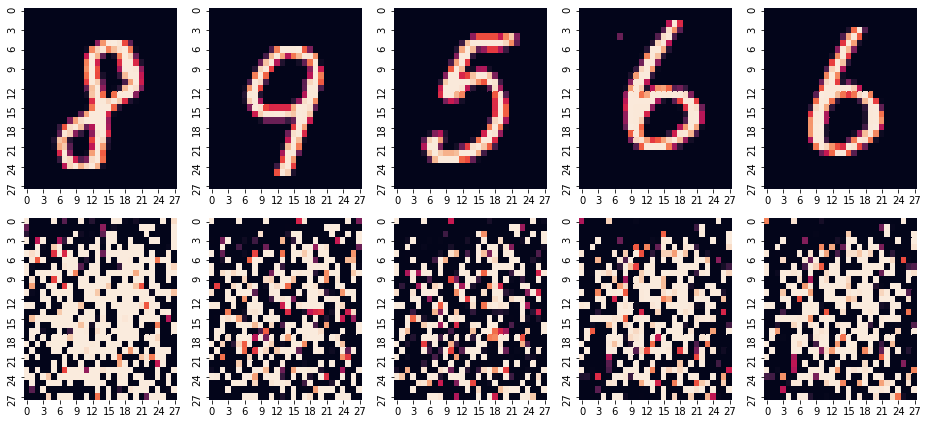

In [31]:
trainer.train(20)

****
Manualy train in the notebook for easier debugging

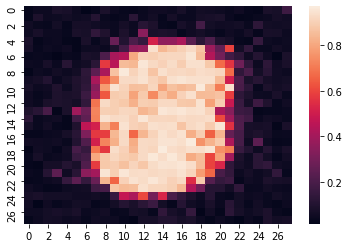

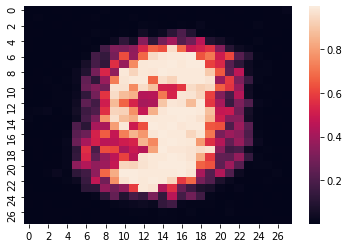

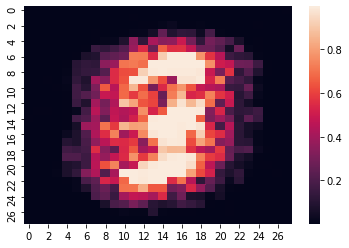

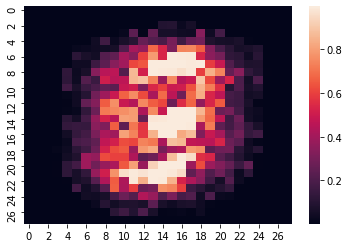

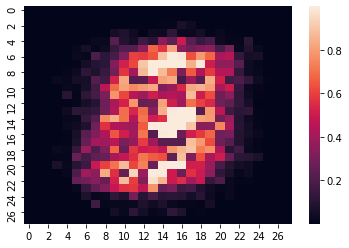

In [15]:
d_z_weight = 1.
disc_g_weight = 1.

z_mu = 0.
z_var = 0.5

n_epochs = 5
for n in tqdm(range(n_epochs), desc='Training'):
    with tqdm(total=len(mnist_dl), desc='epoch ' + str(n)) as batch_bar:
        for batch_i, (real_x, real_y) in enumerate(mnist_dl):
            optim_omega.zero_grad()
            optim_theta.zero_grad()
            optim_gamma.zero_grad()
            
            ## Real Sample
            fl_real_x = real_x.reshape(-1, input_dim)
            ## Gaussian Z
            z_i = torch.empty(fl_real_x.shape[0], z_size).normal_(mean=z_mu, std=z_var)
            
            ## G Sample from Gaussian Z
            g_from_z = gen_m(z_i)
            ## Enc Z from G Sample
            z_i_g = enc_m(g_from_z)
            
            ###
            ## formula 7
            #disc_g_out = disc_m(torch.cat([z_i, g_from_z], dim=1))
            disc_g_out = -torch.log(disc_m(torch.cat([z_i, g_from_z], dim=1)).clamp(1e-8))
            d_z = torch.sqrt((z_i - z_i_g)**2).mean()
                        
            o_hat = (disc_g_weight*disc_g_out.mean() + d_z_weight*d_z)
            o_hat.backward()
            optim_theta.step()
            optim_gamma.step()
            ###########
            ## Enc of real
            ## Real Sample
            fl_real_x = real_x.reshape(-1, input_dim)
            ## Gaussian Z
            z_i = torch.empty(fl_real_x.shape[0], z_size).normal_(mean=z_mu, std=z_var)
            
            ## G Sample from Gaussian Z
            g_from_z = gen_m(z_i)
            
            ## Enc Z from G Sample
            z_i_g = enc_m(g_from_z)
            
            disc_fake_out = disc_m(torch.cat([z_i, g_from_z], dim=1))
            ## 
            disc_real_out = disc_m(torch.cat([z_i_g, fl_real_x], dim=1))
            
            ## Formula 8
            #o_lr = -(torch.log(disc_fake_out) + torch.log(1. - disc_real_out)).mean()
            o_lr = -(torch.log(disc_real_out.clamp(1e-8)) + torch.log(1. - disc_fake_out.clamp(0, 0.999))).mean()
            
            o_lr.backward(retain_graph=False)
            
            optim_omega.step()
            
            #desc = "%.3f %.3f %.3f" % (g_w, g_theta, g_gamma)
            desc = "%.3f %.3f %.3f" % (o_hat, o_lr, d_z)
            batch_bar.set_description(desc)
            batch_bar.update(1)

        fig, ax = matplotlib.pyplot.subplots()
        sns.heatmap((g_from_z[3].reshape(28, 28)).float().detach().numpy(), ax=ax)

****
Viz results of training

In [23]:
real_x_batch, real_y_batch = next(iter(mnist_dl))

fl_real_x = real_x_batch.reshape(-1, input_dim)

In [24]:
real_encs = enc_m(fl_real_x)
g_from_real_z = gen_m(real_encs)

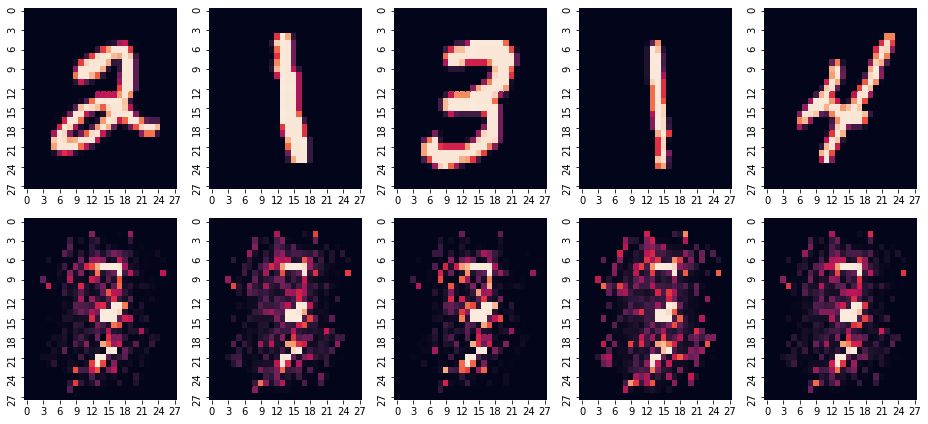

In [25]:
base_plt_i = 5
n_to_plt = 5
fig, axs = matplotlib.pyplot.subplots(figsize=(13, 6), nrows=2, ncols=n_to_plt)
for i in range(n_to_plt):
    _i = base_plt_i + i
    sns.heatmap((fl_real_x[_i].reshape(28, 28)).float().detach().numpy(), 
                ax=axs[0][i], cbar=False)
    
    sns.heatmap((g_from_real_z[_i].reshape(28, 28)).float().detach().numpy(), 
                ax=axs[1][i], cbar=False)
fig.tight_layout()

In [39]:
gen_m(real_encs)

tensor([[0.0007, 0.0004, 0.0004,  ..., 0.0009, 0.0004, 0.0004],
        [0.0006, 0.0003, 0.0003,  ..., 0.0007, 0.0003, 0.0003],
        [0.0007, 0.0004, 0.0004,  ..., 0.0009, 0.0004, 0.0004],
        ...,
        [0.0007, 0.0004, 0.0004,  ..., 0.0009, 0.0004, 0.0004],
        [0.0006, 0.0003, 0.0003,  ..., 0.0007, 0.0003, 0.0003],
        [0.0006, 0.0004, 0.0004,  ..., 0.0008, 0.0004, 0.0003]],
       grad_fn=<SigmoidBackward>)

In [109]:
z_i.shape

torch.Size([32, 2])

In [125]:
ux_t = torch.tensor([[1, 2], [1, 2]]).reshape(-1, 2).float()

In [126]:
ux_t.shape

torch.Size([2, 2])

In [127]:
gen_m.eval()(ux_t)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SigmoidBackward>)

In [34]:
disc_fake_out[:10]

tensor([[0.6634],
        [0.6625],
        [0.6628],
        [0.6618],
        [0.6640],
        [0.6634],
        [0.6627],
        [0.6623],
        [0.6635],
        [0.6624]], grad_fn=<SliceBackward>)

In [35]:
disc_real_out[:10]

tensor([[0.7303],
        [0.7290],
        [0.7294],
        [0.7191],
        [0.7300],
        [0.7307],
        [0.7296],
        [0.7276],
        [0.7269],
        [0.7274]], grad_fn=<SliceBackward>)

<AxesSubplot:>

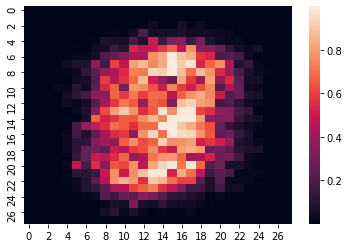

In [48]:
import seaborn as sns
import matplotlib
fig, ax = matplotlib.pyplot.subplots()
sns.heatmap((g_from_z[18].reshape(28, 28)).float().detach().numpy(), ax=ax)

<AxesSubplot:>

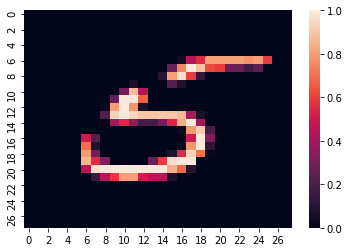

In [14]:
import seaborn as sns
import matplotlib
fig, ax = matplotlib.pyplot.subplots()
sns.heatmap((fl_real_x[0].reshape(28, 28)).float().detach().numpy(), ax=ax)

In [26]:
g_from_z[1]

tensor([ 1.7498e-01, -4.0477e-02, -3.4126e-03, -6.0335e-02,  6.5560e-03,
        -5.7468e-03, -6.4365e-03, -2.7556e-03, -1.4443e-02,  1.0651e-02,
         6.5259e-02,  2.0816e-02,  8.3408e-03,  3.7708e-02,  4.1290e-02,
         1.8012e-03,  2.0961e-04,  1.2260e-02,  8.8800e-03, -3.0472e-03,
        -4.6377e-03,  8.4433e-04,  1.1244e-02, -8.8682e-03,  7.1244e-02,
         1.1075e-02,  1.5433e-03, -1.6232e-02,  7.7651e-03,  4.2078e-03,
        -1.3265e-02, -1.9103e-03, -9.2519e-03,  1.9697e-01, -3.9036e-03,
        -5.3030e-03,  3.2948e-04,  3.3757e-03,  8.4103e-03, -2.0344e-03,
        -1.0256e-02,  2.8455e-03, -4.7058e-03, -1.1009e-01, -1.0709e-01,
         1.7965e-03,  7.8527e-04,  2.3452e-03,  6.1290e-02,  1.4059e-01,
        -1.1430e-02,  1.2627e-02, -1.8574e-02,  6.1415e-03, -2.7495e-03,
        -8.2067e-03,  4.0429e-03, -2.1470e-01,  5.8161e-03,  1.0067e-01,
        -1.8868e-01, -1.8472e-03,  1.0457e-02, -1.0977e-02, -1.1329e-01,
        -5.9509e-04,  5.0579e-03,  1.2184e-01, -2.7

In [17]:
disc_real_out

tensor([[0.7111],
        [0.6928],
        [0.5000],
        [0.5000],
        [0.6844],
        [0.7031],
        [0.5029],
        [0.5002],
        [0.5023],
        [0.5362],
        [0.5000],
        [0.5002],
        [0.5000],
        [0.5541],
        [0.6038],
        [0.5000],
        [0.5000],
        [0.5011],
        [0.7161],
        [0.5895],
        [0.5000],
        [0.5004],
        [0.5014],
        [0.5006],
        [0.5000],
        [0.7234],
        [0.5004],
        [0.5015],
        [0.5000],
        [0.6621],
        [0.6752],
        [0.6366]], grad_fn=<SigmoidBackward>)

In [16]:
disc_fake_out

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SigmoidBackward>)

In [ ]:
n_epochs = 1
for n in tqdm(range(n_epochs)):
    
    with tqdm(total=len(mnist_dl), desc='epoch ' + str(n)) as batch_bar:
        for batch_i, (real_x, real_y) in enumerate(mnist_dl):
            optim_omega.zero_grad()
            optim_theta.zero_grad()
            optim_gamma.zero_grad()
            
            fl_real_x = real_x.reshape(-1, input_dim)
            z_i = torch.empty(fl_real_x.shape[0], z_size).normal_(mean=0, std=0.1)
            g_from_z = gen_m(z_i)
            z_i_g = enc_m(g_from_z)

            ##############
            g_w = -(torch.log(torch.sigmoid(disc_m(torch.cat([z_i, g_from_z], dim=1))))
                    +   torch.log(1 - torch.sigmoid(disc_m(torch.cat([z_i_g, fl_real_x], dim=1))))
                    ).mean()

            # wtf is there notation - distance between z and x?
            g_theta = torch.sqrt((z_i - z_i_g)**2).mean()

            g_gamma = (disc_m(torch.cat([z_i, g_from_z], dim=1)).mean()
                       +  torch.sqrt((z_i - z_i_g)**2).mean())
            ##############


            g_w.backward(retain_graph=True)
            g_theta.backward(retain_graph=True)
            g_gamma.backward(retain_graph=True)

            optim_omega.step()
            optim_theta.step()
            optim_gamma.step()
            desc = "%.3f %.3f %.3f" % (g_w, g_theta, g_gamma)
            batch_bar.set_description(desc)
            batch_bar.update(1)

In [49]:
g_w

tensor(1.3863, grad_fn=<NegBackward>)